In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn

In [2]:
d_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_dir = d_dir / "09_datasets"

p_dir = (Path().cwd().parents[0]).absolute()

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
import graph
import torch
import torch_geometric.utils
import networkx as nx
import lightning.pytorch as pl
import torch.utils.data as data

spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph'
process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'
morph_path = (Path().cwd().parents[0]).absolute() / 'data' / 'morph' / 'outlinePCA.pkl'

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [5]:
from torch_geometric.loader import DataLoader
seed = torch.Generator().manual_seed(42)

name = 'NIH'

# Crate dataset
dataset = graph.GraphDatasetMLP_Moprh(process_path / name, morph_path, process_path / name / 'info.csv', 2, y_name='covid')

train_set, val_set, test_set = graph.train_test_val_split(dataset)

# Create Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
# Read all intensity and extra morphology features 
Xs = []
X_features = []
ys = []
for step, data in enumerate(DataLoader(dataset, batch_size=128)):
    Xs.append(data.x.numpy())
    ys.append(data.y.numpy())
    X_features.append(data.features.numpy())

# Concatenate everything
X_intensity = np.concatenate(Xs)
X_feature = np.concatenate(X_features)

X = np.concatenate([X_intensity, X_feature], axis=1)
y = np.concatenate(ys)

# Define Feature names
features = ['CD21', 'CD20', 'CD68', 'Ki67', 'CD138'] + data.features_names[0]

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import shap
from sklearn import preprocessing 

# Scale input
X_scaled_ori = preprocessing.MinMaxScaler().fit_transform(X)
X_feature = pd.DataFrame(X_scaled_ori, columns=features)
X100 = shap.utils.sample(X_feature, 100) # 100 instances for use as the background distribution

# Train model
model = GradientBoostingClassifier()
model.fit(X_feature, y)

# Shape value
explainer = shap.Explainer(model.predict, X100)
shap_values =  explainer(X_feature)

Permutation explainer: 443it [00:20, 12.78it/s]                         


In [8]:
shap_values

.values =
array([[ 0.01833333, -0.03916667,  0.08333333, ...,  0.05916667,
         0.00083333,  0.        ],
       [-0.02833333, -0.03416667,  0.12083333, ...,  0.00166667,
        -0.00916667, -0.0025    ],
       [-0.04916667, -0.05416667, -0.07333333, ...,  0.00083333,
         0.01833333,  0.00083333],
       ...,
       [ 0.1775    ,  0.0175    , -0.04666667, ...,  0.015     ,
         0.00833333, -0.02333333],
       [ 0.04416667,  0.01333333, -0.04833333, ..., -0.0175    ,
        -0.00416667,  0.0025    ],
       [ 0.16333333,  0.01666667, -0.08666667, ...,  0.0275    ,
        -0.00916667, -0.00416667]])

.base_values =
array([0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61,
       0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61,
       0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61,
       0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61,
       0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.

In [12]:
shap_values.values

array([[ 0.01833333, -0.03916667,  0.08333333, ...,  0.05916667,
         0.00083333,  0.        ],
       [-0.02833333, -0.03416667,  0.12083333, ...,  0.00166667,
        -0.00916667, -0.0025    ],
       [-0.04916667, -0.05416667, -0.07333333, ...,  0.00083333,
         0.01833333,  0.00083333],
       ...,
       [ 0.1775    ,  0.0175    , -0.04666667, ...,  0.015     ,
         0.00833333, -0.02333333],
       [ 0.04416667,  0.01333333, -0.04833333, ..., -0.0175    ,
        -0.00416667,  0.0025    ],
       [ 0.16333333,  0.01666667, -0.08666667, ...,  0.0275    ,
        -0.00916667, -0.00416667]])

In [13]:
X_feature.shape

(442, 38)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


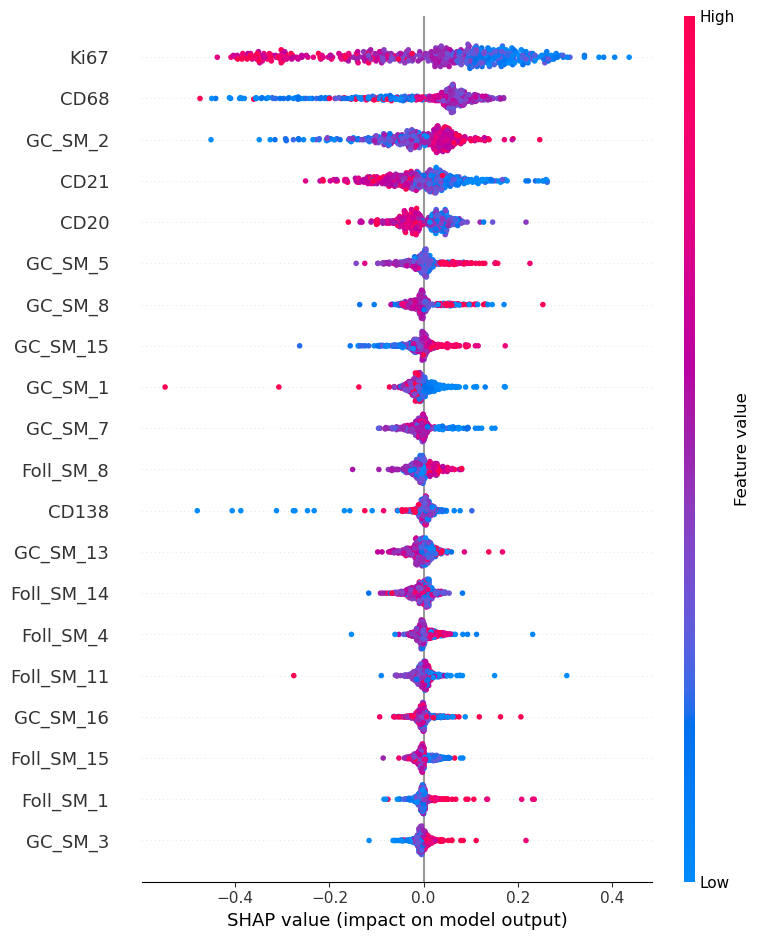

In [9]:
# Plot Shap explenation
shap.summary_plot(shap_values.values, X_feature)

In [12]:
shap_values.values

array([[-0.02083333, -0.02833333,  0.05583333, ...,  0.12416667,
         0.        ,  0.00083333],
       [-0.02666667, -0.0275    ,  0.09      , ...,  0.01166667,
        -0.00416667,  0.00333333],
       [-0.045     , -0.04083333, -0.0525    , ...,  0.01416667,
         0.0175    ,  0.00083333],
       ...,
       [ 0.13083333,  0.02416667, -0.0375    , ...,  0.01083333,
        -0.00666667, -0.015     ],
       [ 0.04833333,  0.02833333, -0.0225    , ..., -0.03416667,
        -0.0025    ,  0.00083333],
       [ 0.15      ,  0.00916667, -0.0475    , ...,  0.025     ,
        -0.00666667, -0.0025    ]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


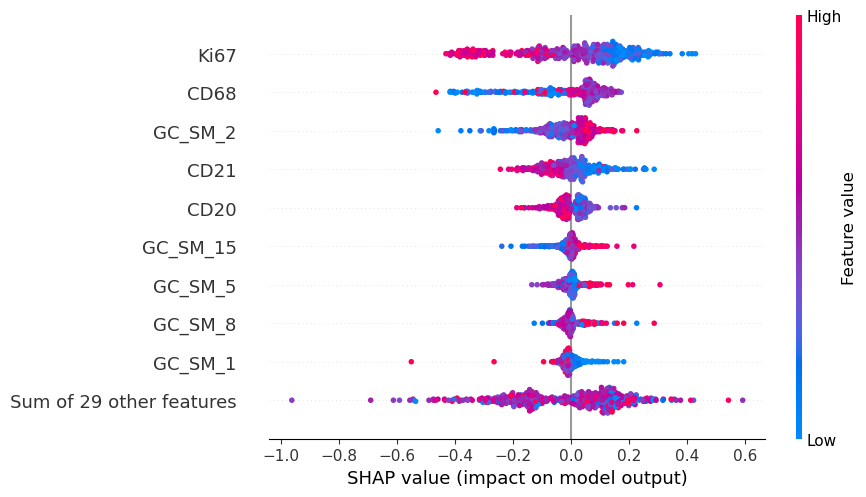

In [9]:
shap.plots.beeswarm(shap_values)


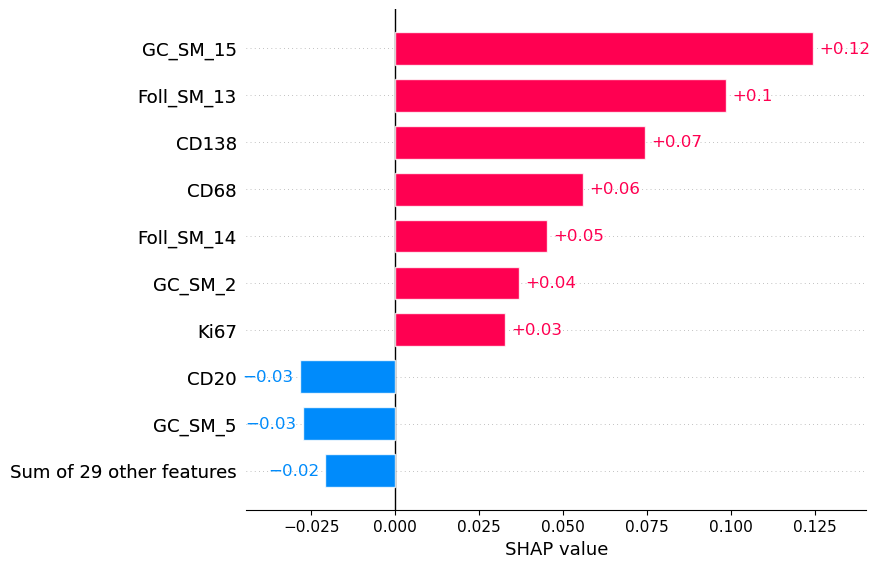

In [10]:
shap.plots.bar(shap_values[0])
